# Working With BART

**Presenter: Max Litster `maxlitster@berkeley.edu`**

This notebook details how users can interact with BART via the command line, Python or MATLAB. 

If you are running these examples from the Binder, BART should be installed and the necessary paths have already been set. 

If you are running these examples locally, you will need [BART](https://github.com/mrirecon/bart) installed and added to your `PATH`. Add the following to your `.bashrc` (and restart/re-`source` your session) to do so:

`export TOOLBOX_PATH=/path/to/bart`

`export PATH=$TOOLBOX_PATH:$PATH`

If the following cell runs correctly and displays a list of BART tools, you're good to go!

Note: The `!` character indicates that the following cell should be executed in bash vs. the native python kernel. It is not necessary when running BART commands from your terminal.

In [5]:
!bart

BART. Available commands are:
avg         bench       bitmask     cabs        caldir      calmat      
carg        casorati    cc          ccapply     cdf97       circshift   
conj        conv        copy        cpyphs      creal       crop        
delta       ecalib      ecaltwo     estdelay    estdims     estshift    
estvar      extract     fakeksp     fft         fftmod      fftrot      
fftshift    filter      flatten     flip        fmac        homodyne    
index       invert      itsense     join        looklocker  lrmatrix    
mandelbrot  mip         moba        nlinv       noise       normalize   
nrmse       nufft       ones        pattern     phantom     pics        
pocsense    poisson     poly        repmat      reshape     resize      
rmfreq      rof         rss         sake        saxpy       scale       
sdot        show        slice       spow        sqpics      squeeze     
ssa         std         svd         tgv         threshold   toimg       
traj        transpose

## Command-Line Interface (CLI)

### BART Command Structure

All BART commands are structured in the following way:

`bart` + `command` + `options` + `input/output`

Where we can view the full usage string and optional arguments with the `-h` flag.

For example, the following command demonstrates the full suite of options for generating a numerical phantom in the image or k-space domain:

In [6]:
!bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <string>] [-G ...] [-T ...] [-x d] [-g d] [-3] [-b] <output>

Image and k-space domain phantoms.

-s nc      	nc sensitivities
-S nc      	Output nc sensitivities
-k		k-space
-t file      	trajectory
-G		geometric object phantom
-T		tubes phantom
-x n      	dimensions in y and z
-g n=1,2      	select geometry for object phantom
-3		3D
-b		create basis for geometry
-h		help


Brackets indicate optional arguments. `d` indicates a base-10 (decimal) argument.

## Python Bindings

BART comes equipped with Python Bindings that easily integrate with popular scientific computing libraries in Python. This tutorial introduces the structure of the BART python module.

You will need BART as well as `numpy` and `matplotlib` installed to run the sensitivity map demo. If the following cells run without error, you are good to go:

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

### Setup

If you're running in the Binder, the paths should be updated and you should be all set to run the following demos. 

If you are running locally, you will need to directly import the `bart` module. To do this, you can add BART's python directory to your `PYTHONPATH` environment variable. Add the following line to your `.bashrc` to do this:

`export PYTHONPATH="${TOOLBOX_PATH}/python:$PYTHONPATH"`

Where `TOOLBOX_PATH` is the location of your BART install.

This way, we can import the `bart` module as well as `cfl`, our utility file for dealing with BART's data format: a `.hdr` header file and a `.cfl` file of complex-float data.

After having updated your `PYTHONPATH`, the following cells should execute error-free:

In [4]:
from bart import bart
import cfl

### BART Command Structure

The `bart` module allows a user to execute any BART command-line tool via the following format:

`<outputs> = bart(<nargs>, <command>, <arguments>, ...)`

Where:

`<outputs>`: the output of a BART command

`<nargs>`: the number of outputs

`<command>`: the command string and necessary flags

`<arguments>`: the `<nargs>` data files passed in for use in the function

In [8]:
!bart fft -h

Usage: fft [-u] [-i] [-n] bitmask <input> <output>

Performs a fast Fourier transform (FFT) along selected dimensions.

-u		unitary
-i		inverse
-n		un-centered
-h		help


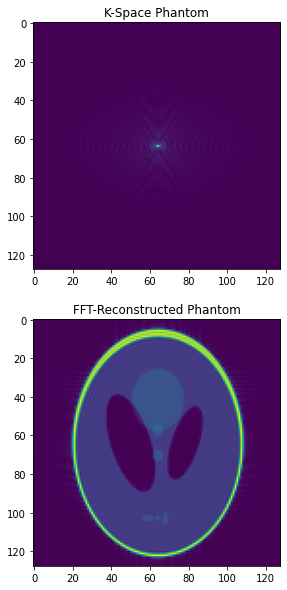

In [9]:
# Generating a k-space phantom and applying an inverse FFT.
shepp_kspace = bart(1, "phantom -k -x 128")
shepp_fft = bart(1, "fft -i 3", shepp_kspace)

fig, ax = plt.subplots(nrows=2, figsize=(6, 10))
ax[0].set_title("K-Space Phantom")
ax[0].imshow(abs(shepp_kspace))

ax[1].set_title("FFT-Reconstructed Phantom")
ax[1].imshow(abs(shepp_fft))

A Note about Data Formats: Saving and loading files are not Python in the purest sense, in that data is not stored in RAM the entire time during execution. Under the hood, the Python bindings are writing `.hdr`/`.cfl` files to and from the disk. A RAM disk can be used if users are looking to improve performance in this aspect.

### Writing to and From `.cfl` Files

The `cfl` library has some helpful tools to save or load BART data into a numpy-compatible format. In the first example, we will create a complex float array in numpy and then load it into BART from the command line. In the second example, I generate an array via the CLI and load it into Python via the `cfl` library.

In [10]:
A = np.array([1+1j, 2+3j, 3+5j])
cfl.writecfl('A', A)
!bart show A

+1.000000e+00+1.000000e+00i	+2.000000e+00+3.000000e+00i	+3.000000e+00+5.000000e+00i


It's very important to note that the filename does not include any extensions. This is because BART writes out separate header (`.hdr`) and complex float (`.cfl`) files. 

In [11]:
!bart ones 1 1 B
B = cfl.readcfl('B')
B

array([1.+0.j], dtype=complex64)

### Example: Estimating and Plotting Coil Sensitivity

In the following example, we use BART's `ecalib` tool to estimate coil sensitivity, and then we use matplotlib to plot the results. This is taken from a larger example from an earlier workshop that uses Python to estimate the g-factor of parallel imaging data. [More information is available here](https://github.com/mrirecon/bart-workshop).

In [12]:
# x and y dimensions
nx = 128
ny = 128

# number of coils
nc = 8

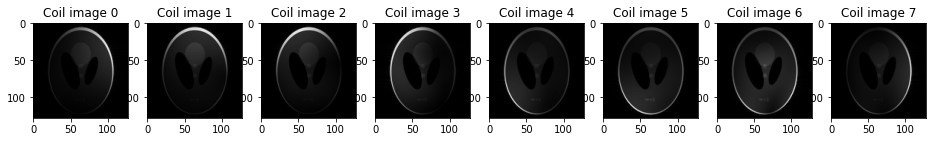

In [13]:
ksp = bart(1, 'phantom -x {} -s {} -k'.format(nx, nc)).squeeze()
cimg = bart(1, 'fft -iu 3', ksp)

plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(cimg[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil image {}'.format(i))

The call to `bart` returns a numpy array. We are able to seamlessly integrate this data into our `matplotlib` setup.

Next, we use `bart ecalib` to get our coil sensitivities, and plot them accordingly.

In [14]:
!bart ecalib -h

Usage: ecalib [-t f] [-c f] [-k ...] [-r ...] [-m d] [-S] [-W] [-I] [-1] [-P] [-v f] [-a] [-d d] <kspace> <sensitivites> [<ev-maps>]

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold      	This determined the size of the null-space.
-c crop_value      	Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize      	kernel size
-r cal_size      	Limits the size of the calibration region.
-m maps      	Number of maps to compute.
-S		create maps with smooth transitions (Soft-SENSE).
-W		soft-weighting of the singular vectors.
-I		intensity correction
-1		perform only first part of the calibration
-P		Do not rotate the phase with respect to the first principal component
-v variance      	Variance of noise in data.
-a		Automatically pick thresholds.
-d level      	Debug level
-h		help


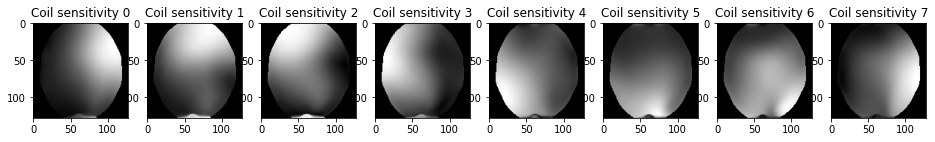

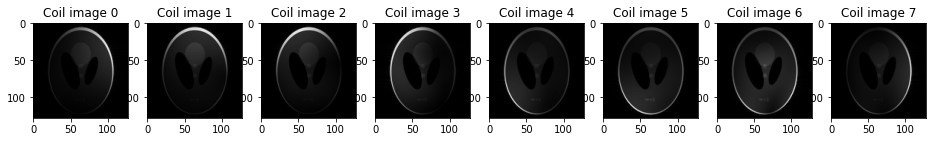

In [15]:
sens = bart(1, 'ecalib -m1', ksp[:,:,None,:]).squeeze()

plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(sens[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil sensitivity {}'.format(i))
    
plt.figure(figsize=(16,20))
for i in range(nc):
    plt.subplot(1, nc, i+1)
    plt.imshow(abs(cimg[:,:,i]).squeeze(), cmap='gray')
    plt.title('Coil image {}'.format(i))

## MATLAB Bindings

Similar bindings are available for MATLAB, located in `$TOOLBOX_PATH/matlab`.

Navigate to this directory in MATLAB, and run `startup` to enable the BART bindings. 

For example, to create a phantom in MATLAB, one can run:

`>>> shepp = bart('phantom -x 64')`

The general structure of BART commands in MATLAB is as follows:

`<outputs> = bart(<command>, <inputs>)`

The `cfl` commands are also available in MATLAB as `writecfl` and `readcfl` respectively.